Player Clustering  
========
Is it possible to separate AUDL players into groups based on their role and playstyle?

Only 6 of the 24 AUDL teams have rosters with player positions specified, and some teams have different position names than others. These teams may be useful later, but it looks like we do not have suffieicnt information to do traditional classification. Instead we will have to take a clustering/unsupervised learning approach to identify different groups of players. 

__The teams with player positions on their rosters:__  
http://www.myalleycats.com/#!team/c10ek  
http://the-dcbreeze.com/2016-roster-2/  
https://www.laaviators.com/2015-roster/  
http://ottawaoutlaws.com/team/roster/  
http://torontorush.com/club/toronto-rush/  
http://www.sdgrowlers.com/roster/

From the outset, we suspect that AUDL teams follow traditional ultimate schemes where players are split into offense/defense and handlers/cutters. This is the perfect appication for unsupervised clustering, as we expect that these groups exist but we do not have data for all players for it. 

### Playing with sklearn.cluster.KMeans

In [41]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pdb

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.cluster import KMeans
from sklearn import datasets

from scipy.spatial.distance import cdist, euclidean
from scipy.stats import percentileofscore

pd.set_option('display.max_columns', None)

### Processing data

In [4]:
%%bash 
ls South

AtlantaHustle2015-stats.csv
CharlotteExpress2015-stats.csv
JacksonvilleCannons2015-stats.csv
NashvilleNightwatch2015-stats.csv
RaleighFlyers2015-stats.csv


In [5]:
# we'll test all of this with just Raleigh Flyers data
raleigh = pd.read_csv("South/RaleighFlyers2015-stats.csv")

For our k-means algorithm we want an n_item x n_feature matrix where each of the items is a player and each of the features is a statistical parameter that we think will help us cluster. This means that we need to decide what parameters we are interested in. I propose:  
- Percentage of points played that were O points
- Percentage of points where player scores a goal
- Percentage of points where player earns an assist

In [6]:
def clean_df(df):
    """Removes rows with improperly formatted data
    
    df: pandas dataframe with throw-by-throw data
    
    returns: pandas df"""
    
    df = df[pd.isnull(df["Player 2"]) == False]
    return df[pd.isnull(df["Player 1"]) == False]


In [7]:
def get_players(df):
    """returns list of all players present in throw-by throw pandas dataframe"""
    players = pd.unique(df.loc[0:, "Player 0": "Player 27"].values.ravel())
    return [player for player in players if not pd.isnull(player)]

In [8]:
get_players(clean_df(raleigh))

['Snoke D',
 'Bowen J',
 'Tarasi D',
 'Mitche T',
 'Nether J',
 'Dieter B',
 'Casey B',
 'Clark B',
 'Matthe R',
 'Hastin J',
 'Zhou M',
 'Colema J',
 'Snell B',
 'Moore M',
 'Chandl D',
 'McGoog J',
 'Maxsta X',
 'Richar D',
 'Green T',
 'Cretel J',
 'Bender S',
 'Pope T',
 'Allen J',
 'Goode R',
 'Hartzo J',
 'Neve M',
 'Willia J',
 'Saul N',
 'Lin M',
 'McAlis T',
 'Taylor H',
 'Ryan A',
 'Stumpf M',
 'Cooper S',
 'Poulos S',
 'Colicc C',
 'Weeks P',
 'Jessi J']

In [9]:
def summarize_points(df):
    """Gives point-by-point summaries
    
    df: pandas dataframe throw-by-throw data
    
    returns: pandas dataframe"""
    
    return df.groupby(["Date/Time", "Our Score - End of Point", "Their Score - End of Point"]).last().reset_index() 


In [10]:
summarize_points(raleigh).head(3)

,Date/Time,Our Score - End of Point,Their Score - End of Point,Tournamemnt,Opponent,Point Elapsed Seconds,Line,Event Type,Action,Passer,Receiver,Defender,Hang Time (secs),Player 0,Player 1,Player 2,Player 3,Player 4,Player 5,Player 6,Player 7,Player 8,Player 9,Player 10,Player 11,Player 12,Player 13,Player 14,Player 15,Player 16,Player 17,Player 18,Player 19,Player 20,Player 21,Player 22,Player 23,Player 24,Player 25,Player 26,Player 27,Elapsed Time (secs)
0,2015-04-11 18:59,0,1,AUDL,Atlanta Hustle,16,D,Defense,Goal,NaN,NaN,Anonymous,4,Clark B,Matthe R,Green T,Cretel J,Zhou M,Bender S,Pope T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
1,2015-04-11 18:59,0,2,AUDL,Atlanta Hustle,41,O,Defense,Goal,Allen J,Anonymous,Anonymous,NaN,Bowen J,Snoke D,Mitche T,Tarasi D,Dieter B,Casey B,Allen J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102
2,2015-04-11 18:59,1,2,AUDL,Atlanta Hustle,65,O,Offense,Goal,Snoke D,Neve M,Anonymous,NaN,Snoke D,Goode R,Tarasi D,Chandl D,Neve M,Cretel J,Allen J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225


In [11]:
def player_summaries(df):
    """Summarize statistics for all players
    
    df: pandas dataframe with throw-by-throw data
    
    returns: pandas dataframe"""
    
     # does not mutate the original
    df = clean_df(df)
    
    players = get_players(df)
    stats = {"team"      : "",
             "goals"     : 0,
             "assists"   : 0,
             "ds"        : 0,
             "throwaways": 0,
             "drops"     : 0,
             "opoints"   : 0,
             "dpoints"   : 0}
    team_stats = {player: dict(stats) for player in players}
    
    # to keep track of the column number
    cols = list(df.columns)
    passer   = cols.index("Passer")
    receiver = cols.index("Receiver")
    p0       = cols.index("Player 0")
    p27      = cols.index("Player 27")
    line     = cols.index("Line")
    
    
    # add goals and assists
    ogoals = df[(df.Action == "Goal") & (df["Event Type"] == "Offense")]
    for row in ogoals.values:
        # we have try/execpt here for unpredictable data impurities
        # eg: "Anonymous" for one of the assists, stat-keeper must
        # have not known who threw it (?) callahan?
        try: team_stats[row[passer]]["assists"] += 1
        except: pass
        try: team_stats[row[receiver]]["goals"]  += 1
        except: pass
        
    # add D's
    ds = df.Defender[df.Action == "D"]
    for player in ds:
        try: team_stats[player]["ds"] += 1
        except: pass
        
        
    # add turnovers and drops
    turns = df[((df.Action == "Throwaway") & (df["Event Type"] == "Offense")) | (df.Action == "Drop") ]
    for row in turns.values:
        if row[8] == "Throwaway":
            try: team_stats[row[passer]]["throwaways"] += 1
            except: pass
        else:
            try: team_stats[row[receiver]]["drops"]     += 1
            except: pass
    
    # add points
    point_summaries = summarize_points(df)
    line = list(point_summaries.columns).index("Line")
    for row in point_summaries.values:
        player_cols = row[p0:p27]
        players = [player for player in player_cols if not pd.isnull(player)]
        if row[line] == "O":
            for player in players:
                team_stats[player]["opoints"] += 1
        else:
            for player in players:
                team_stats[player]["dpoints"] += 1
                
    summary = pd.DataFrame.from_dict(team_stats, orient="index").sort_values("goals", ascending=False)
    summary = summary[["team", "goals", "assists", "ds", "throwaways", "drops", "opoints", "dpoints"]]
    summary["totalpoints"] = summary["opoints"] + summary["dpoints"]
    summary["pct_opoints"] = summary["opoints"] / [float(x) for x in summary["totalpoints"]]
    summary["pct_goal"]    = summary["goals"]   / [float(x) for x in summary["totalpoints"]]
    summary["pct_assist"]  = summary["assists"] / [float(x) for x in summary["totalpoints"]]
    summary["pct_d"]       = summary["ds"]      / [float(x) for x in summary["totalpoints"]]
    
    return summary

In [12]:
summary_ral = player_summaries(raleigh)
summary_ral.head()

,team,goals,assists,ds,throwaways,drops,opoints,dpoints,totalpoints,pct_opoints,pct_goal,pct_assist,pct_d
Allen J,,62,60,14,35,5,299,119,418,0.715311,0.148325,0.143541,0.033493
Bowen J,,62,49,7,27,10,288,50,338,0.852071,0.183432,0.144970,0.020710
Mitche T,,26,21,12,25,9,283,83,366,0.773224,0.071038,0.057377,0.032787
Neve M,,25,12,12,6,3,158,87,245,0.644898,0.102041,0.048980,0.048980
Snoke D,,25,29,11,12,2,254,39,293,0.866894,0.085324,0.098976,0.037543


We now have the matrix with the preliminary statistics we want to cluster on. Let's try kmeans and see what we can see.

In [13]:
cluster_cols = summary_ral[["pct_opoints", "pct_goal", "pct_assist"]]
model = KMeans(n_clusters=5).fit(cluster_cols.values)
summary_ral["cluster"] = model.labels_
summary_ral.groupby("cluster").count()

,team,goals,assists,ds,throwaways,drops,opoints,dpoints,totalpoints,pct_opoints,pct_goal,pct_assist,pct_d
cluster,,,,,,,,,,,,,
0,7,7,7,7,7,7,7,7,7,7,7,7,7
1,16,16,16,16,16,16,16,16,16,16,16,16,16
2,6,6,6,6,6,6,6,6,6,6,6,6,6
3,5,5,5,5,5,5,5,5,5,5,5,5,5
4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [14]:
summary_ral.groupby("cluster").mean()

,goals,assists,ds,throwaways,drops,opoints,dpoints,totalpoints,pct_opoints,pct_goal,pct_assist,pct_d
cluster,,,,,,,,,,,,
0,6.428571,5.285714,3.000000,4.857143,1.857143,48.142857,54.428571,102.571429,0.465185,0.070970,0.051329,0.026445
1,5.500000,3.437500,6.000000,3.250000,0.937500,7.062500,120.500000,127.562500,0.046172,0.043458,0.023935,0.048465
2,26.500000,30.333333,7.166667,17.333333,5.166667,235.833333,44.333333,280.166667,0.847896,0.090626,0.107403,0.023243
3,23.400000,22.800000,8.000000,13.600000,2.800000,144.400000,64.200000,208.600000,0.678828,0.107672,0.102165,0.043431
4,3.500000,8.750000,7.000000,9.250000,1.500000,29.500000,117.750000,147.250000,0.195561,0.028462,0.040614,0.078472


Let's try to use the elbow method to see what the optimal number of clusters is

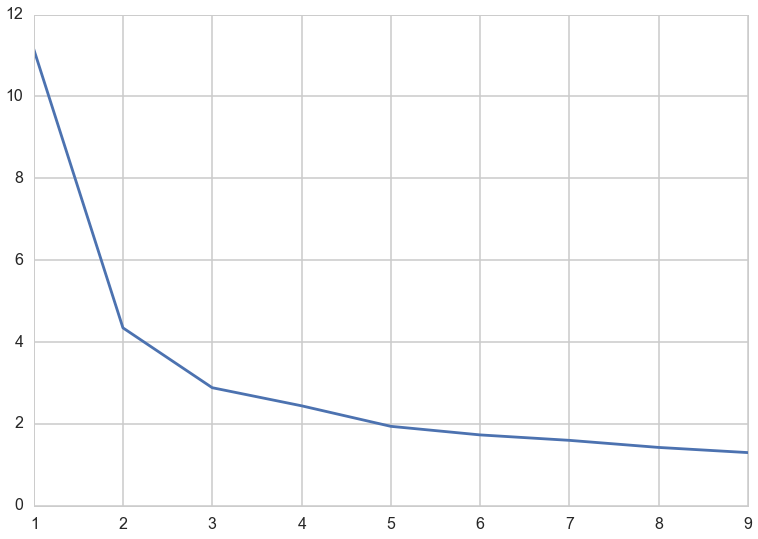

In [15]:
num_clusters = range(1, 10)
models = [KMeans(n_clusters = x) for x in num_clusters]
def score_from_model(model):
    predicted = model.fit_predict(cluster_cols.values)
    centroids = [model.cluster_centers_[x] for x in predicted]
    dist_sum = 0
    for i in range(0, len(predicted)):
        dist_sum += euclidean(cluster_cols.values[i], centroids[i])
    return dist_sum
scores = [score_from_model(model) for model in models]
scores

plt.plot(num_clusters, scores)


## Trying all of this with team-combined csv

In [16]:
combined = pd.read_csv("combined.csv")
combined = clean_df(combined)
combined = combined.drop("Unnamed: 0", axis=1)

C:\Users\Ryan\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (21,22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
all_players = player_summaries(combined)
all_players["goal_percentile"] = [percentileofscore(all_players["pct_goal"], x) / 100.0 for x in all_players["pct_goal"]]
all_players["assist_percentile"] = [percentileofscore(all_players["pct_assist"], x) / 100.0 for x in all_players["pct_assist"]]
cluster_cols = all_players[["pct_opoints", "goal_percentile", "assist_percentile"]]

After reading in the data we'll use k-means to create player clusters. We will first explore using the elbow method to see if there is an optimal number of clusters.

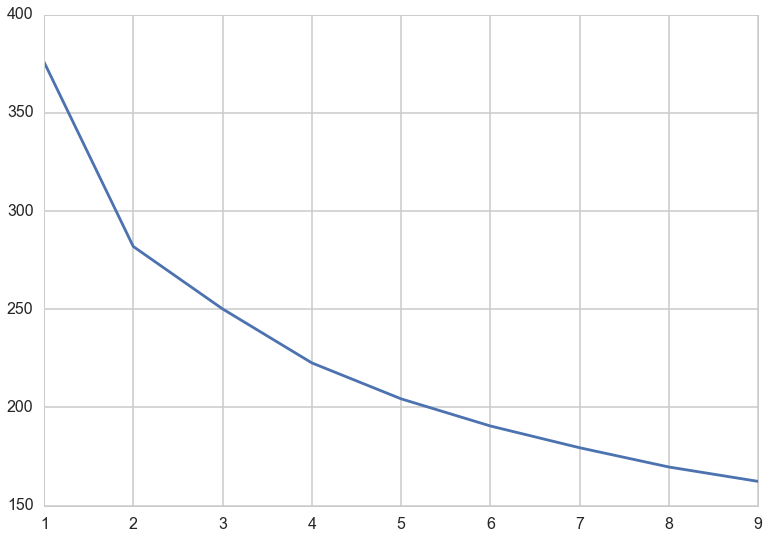

In [18]:
num_clusters = range(1, 10)
models = [KMeans(n_clusters = x) for x in num_clusters]
def score_from_model(model):
    predicted = model.fit_predict(cluster_cols.values)
    centroids = [model.cluster_centers_[x] for x in predicted]
    dist_sum = 0
    for i in range(0, len(predicted)):
        dist_sum += euclidean(cluster_cols.values[i], centroids[i])
    return dist_sum
scores = [score_from_model(model) for model in models]
scores

plt.plot(num_clusters, scores)

There doesn't seem to be an obvious "elbow" for us to separate clusters into. Perhaps we could say that the elbow is at 2, but that would most likely just be splitting players into clusters by offense/defense. We know we want at least four (offensive handler, offensive cutter, defensive handler, defensive cutter), so that should be a lower bound. Let's take a look at what the clusters end up being for a few cases.

### 4-cluster model

In [19]:
model = KMeans(n_clusters=4).fit(cluster_cols.values)
all_players["cluster"] = model.labels_
all_players.groupby("cluster").count().iloc[0:, 0]

cluster
0    222
1    194
2    145
3    216
Name: team, dtype: int64

In [20]:
all_players.groupby("cluster").mean()

,goals,assists,ds,throwaways,drops,opoints,dpoints,totalpoints,pct_opoints,pct_goal,pct_assist,pct_d,goal_percentile,assist_percentile
cluster,,,,,,,,,,,,,,
0,2.644144,3.581081,4.099099,4.743243,1.108108,20.945946,84.891892,105.837838,0.195967,0.021328,0.027461,0.035106,0.211587,0.279155
1,23.505155,20.664948,6.886598,15.051546,3.670103,153.525773,49.572165,203.097938,0.754226,0.115208,0.098855,0.033672,0.804376,0.743684
2,5.358621,14.427586,5.027586,15.668966,2.048276,113.510345,55.475862,168.986207,0.677683,0.029975,0.083276,0.028577,0.286979,0.658514
3,11.083333,6.550926,7.791667,6.060185,1.708333,36.828704,104.472222,141.300926,0.246165,0.082355,0.042592,0.049824,0.668365,0.404020


### 5-cluster model

In [31]:
model = KMeans(n_clusters=5).fit(cluster_cols.values)
all_players["cluster"] = model.labels_
all_players.groupby("cluster").count().iloc[0:, 0]

cluster
0    168
1    184
2    184
3    135
4    106
Name: team, dtype: int64

In [33]:
all_players.groupby("cluster").mean()

,goals,assists,ds,throwaways,drops,opoints,dpoints,totalpoints,pct_opoints,pct_goal,pct_assist,pct_d,goal_percentile,assist_percentile
cluster,,,,,,,,,,,,,,
0,12.202381,4.511905,7.333333,4.964286,1.797619,41.857143,94.232143,136.089286,0.278680,0.091091,0.029575,0.049005,0.711746,0.300948
1,23.413043,21.478261,6.869565,15.576087,3.657609,156.440217,48.456522,204.896739,0.760816,0.114785,0.101973,0.033335,0.802834,0.762730
2,2.581522,2.407609,3.820652,3.918478,1.065217,19.608696,78.793478,98.402174,0.195817,0.021303,0.020273,0.034979,0.212177,0.215020
3,6.911111,13.074074,7.600000,11.096296,1.622222,43.496296,118.037037,161.533333,0.257604,0.042038,0.081091,0.043807,0.385104,0.697221
4,5.207547,13.141509,4.084906,15.424528,2.207547,127.839623,36.726415,164.566038,0.789103,0.030204,0.076793,0.023724,0.289393,0.607641


As we can see from the two summaries above, there are clear offensive handlers and cutters from both models (hight % opoints, cutters have high assist and goal percentages, handlers have high assist percentage). However, the breakdown seems to be not as clear for defensive players. In the 4-cluster model, there are clear defensive cutters, but the 4th cluster seems to be role-players (they do not have high assist % or goal %). The 5-cluster model creates 3 defensive player groups, one with role players, one with handlers, and one with cutters. We will go with this 5-cluster group for our model.

In [148]:
# defining clusters in plaintext
all_players.cluster[all_players.cluster == 3] = "d_handler"
all_players.cluster[all_players.cluster == 2] = "d_roleplayer"
all_players.cluster[all_players.cluster == 1] = "o_cutter"
all_players.cluster[all_players.cluster == 0] = "d_cutter"
all_players.cluster[all_players.cluster == 4] = "o_handler"

# summary statistics now with labels
cluster_summary = all_players.groupby("cluster").mean()
cluster_summary

,team,goals,assists,ds,throwaways,drops,opoints,dpoints,totalpoints,pct_opoints,pct_goal,pct_assist,pct_d,goal_percentile,assist_percentile
cluster,,,,,,,,,,,,,,,
d_cutter,NaN,12.202381,4.511905,7.333333,4.964286,1.797619,41.857143,94.232143,136.089286,0.278680,0.091091,0.029575,0.049005,0.711746,0.300948
d_handler,NaN,6.911111,13.074074,7.600000,11.096296,1.622222,43.496296,118.037037,161.533333,0.257604,0.042038,0.081091,0.043807,0.385104,0.697221
d_roleplayer,NaN,2.581522,2.407609,3.820652,3.918478,1.065217,19.608696,78.793478,98.402174,0.195817,0.021303,0.020273,0.034979,0.212177,0.215020
o_cutter,NaN,23.413043,21.478261,6.869565,15.576087,3.657609,156.440217,48.456522,204.896739,0.760816,0.114785,0.101973,0.033335,0.802834,0.762730
o_handler,NaN,5.207547,13.141509,4.084906,15.424528,2.207547,127.839623,36.726415,164.566038,0.789103,0.030204,0.076793,0.023724,0.289393,0.607641


We will save these clusters into a .csv so we do not have to do clustering again.

In [35]:
all_players.to_csv("all_players.csv")

In [42]:
# read saved dataframe back in
all_players = pd.DataFrame.from_csv("all_players.csv")
all_players.head()

,team,goals,assists,ds,throwaways,drops,opoints,dpoints,totalpoints,pct_opoints,pct_goal,pct_assist,pct_d,goal_percentile,assist_percentile,cluster
Beards E,NaN,72,8,13,2,11,292,88,380,0.768421,0.189474,0.021053,0.034211,0.978121,0.192407,d_cutter
Kittre B,NaN,68,37,26,23,3,263,153,416,0.632212,0.163462,0.088942,0.062500,0.954955,0.777349,o_cutter
Matt S,NaN,66,17,3,3,6,240,29,269,0.892193,0.245353,0.063197,0.011152,0.997426,0.619048,o_cutter
Vatz D,NaN,62,9,4,7,8,242,47,289,0.837370,0.214533,0.031142,0.013841,0.987130,0.299871,o_cutter
Allen J,NaN,62,60,14,35,5,299,119,418,0.715311,0.148325,0.143541,0.033493,0.934363,0.934363,o_cutter


In [102]:
blues = sns.color_palette("Blues")
reds  = sns.color_palette("Reds")
position_colors = {"o_cutter" : blues[4],
                   "o_handler" : blues [2],
                   "d_cutter" : reds[4],
                   "d_handler" : reds[2],
                   "d_roleplayer": reds[0]}
position_order = ["d_roleplayer",
                  "d_handler",
                  "d_cutter",
                  "o_handler",
                  "o_cutter"]

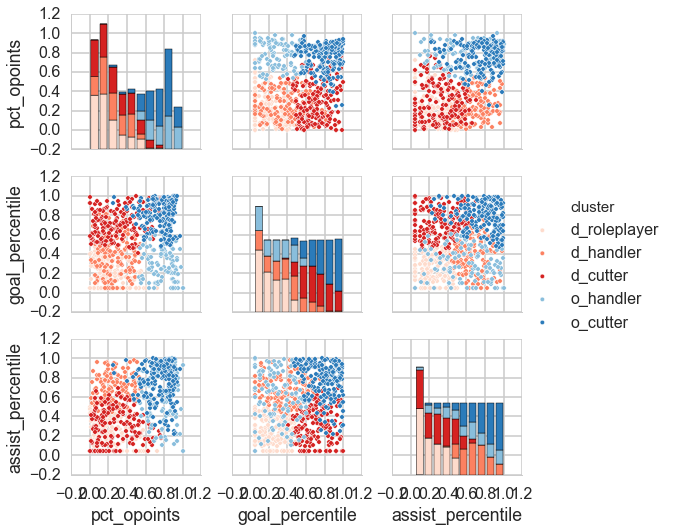

In [103]:
sns.pairplot(all_players, vars=["pct_opoints", "goal_percentile", "assist_percentile"],
             hue="cluster", hue_order=position_order, palette=position_colors)

Investigating our clusters above we can see a few things. One of the first is that our suspicion about offensive/defensive players: we can see that the histogram for percentage of offensive points played is bimodal, with players tending to play their points on one particular side of the disc. We can also see the large group of defensive role players in the bottom corner of the plot. While it is unfortunate for classification that we cannot really tell if these players are handlers of cutters, it is necessary to do a 5-cluster model so that we have some method of identifying defensive handlers.

We also observe a very uniform distribution for the assist and goal percentiles - this is to be expected due to the nature of the fact that we trandformed the data into a percentile scale. Let's examine the data without the transformation.

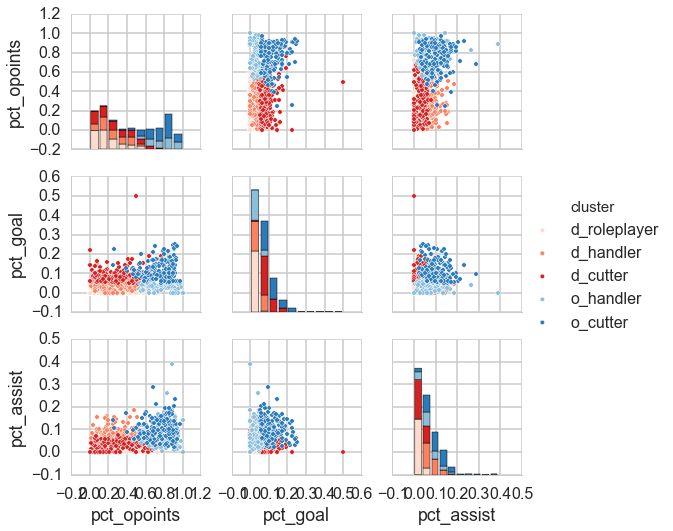

In [104]:
sns.pairplot(all_players, vars=["pct_opoints", "pct_goal", "pct_assist"],
             hue="cluster", hue_order=position_order, palette=position_colors)

It is interesting to note that all of these data are very right-skewed. The majority of players have very low goal and assist percentages. This shows that the best players are racking up most of the goals and assists.

Another interesting observation lies within our "offensive cutter" cluster. This cluster not only has a high percentage of goals, but also a high percentage of assists. This goes to show that the best players at the profssional level are skilled on both sides of the disc. We can look at some of the best offensive cutters to see that they are both goal scoring and assist making machines.

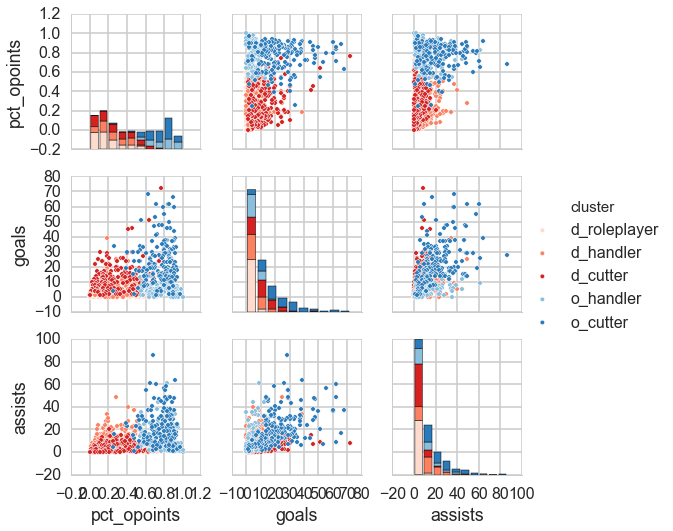

In [107]:
sns.pairplot(all_players, vars=["pct_opoints", "goals", "assists"],
             hue="cluster", hue_order=position_order, palette=position_colors)

In [27]:
# top offensive cutters also tend to be great throwers
all_players.loc[["Kittre B", "Allen J", "DeGiro T"], ]

,team,goals,assists,ds,throwaways,drops,opoints,dpoints,totalpoints,pct_opoints,pct_goal,pct_assist,pct_d,goal_percentile,assist_percentile,cluster
Kittre B,,68,37,26,23,3,263,153,416,0.632212,0.163462,0.088942,0.062500,0.954955,0.777349,o_handler
Allen J,,62,60,14,35,5,299,119,418,0.715311,0.148325,0.143541,0.033493,0.934363,0.934363,o_handler
DeGiro T,,28,86,13,19,3,203,95,298,0.681208,0.093960,0.288591,0.043624,0.777992,0.998713,o_handler


## Evaluating clusters 
We want to see how different the statistics are for these different cluters. Let's first look at the parameters we used to cluster on.

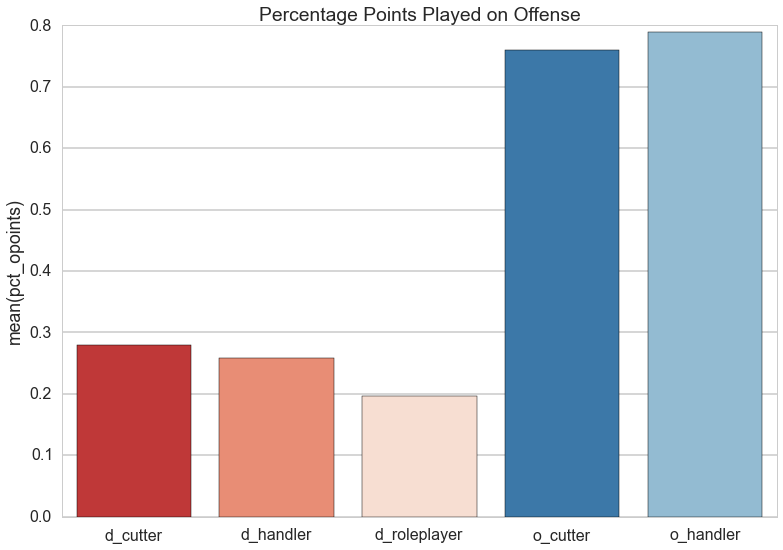

In [165]:
ax = plt.gca()
sns.barplot(list(cluster_summary.index), cluster_summary.pct_opoints,
            palette=position_colors, ax=ax)
ax.set_title("Percentage Points Played on Offense")

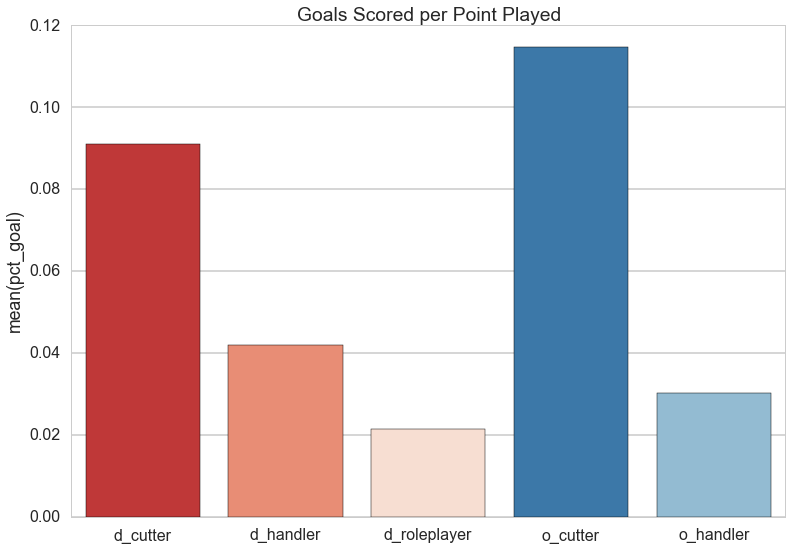

In [166]:
ax = plt.gca()
sns.barplot(list(cluster_summary.index), cluster_summary.pct_goal,
            palette=position_colors, ax=ax)
ax.set_title("Goals Scored per Point Played")

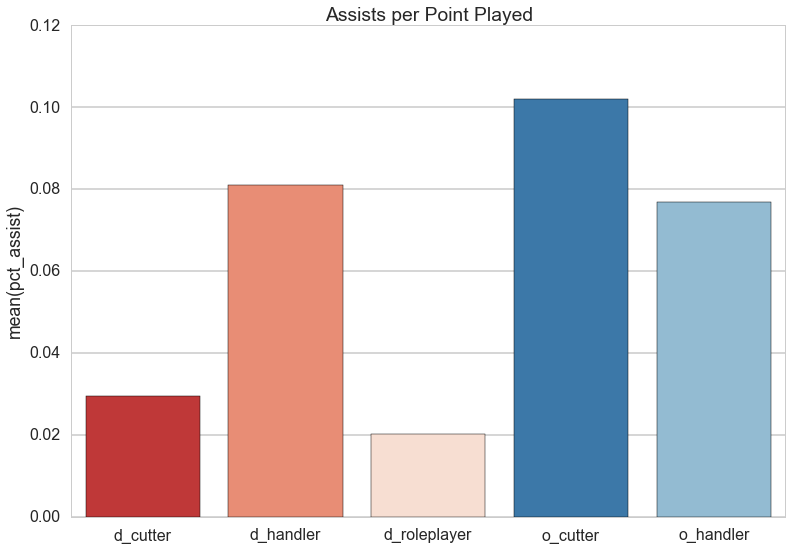

In [168]:
ax = plt.gca()
sns.barplot(list(cluster_summary.index), cluster_summary.pct_assist,
            palette=position_colors, ax=ax)
ax.set_title("Assists per Point Played")

As we can see from the plots above, offensive players, of course, play most of their points starting on offense. Handlers tend to assist more than they score, and cutters tend to score more than they assist. The one caveat is offensive cutters, who seem to be profficient in both scoring goals and getting assists.

#### Offense / Defense

In [176]:
o_cutters = all_players[all_players.cluster == "o_cutter"]
o_handlers = all_players[all_players.cluster == "o_handler"]
d_cutters = all_players[all_players.cluster == "d_cutter"]
d_handlers = all_players[all_players.cluster == "d_handler"]
d_roleplayers = all_players[all_players.cluster == "d_roleplayer"]
offense = pd.concat([o_cutters, o_handlers])
defense = pd.concat([d_cutters, d_handlers, d_roleplayers])
cutters = pd.concat([o_cutters, d_cutters])
handlers = pd.concat([o_handlers, d_handlers])

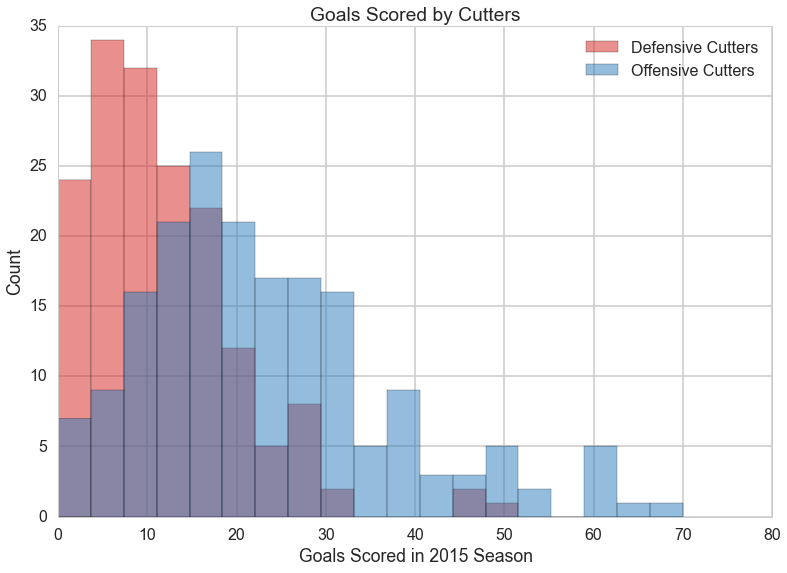

In [138]:
bins = np.linspace(0, 70, 20)

plt.hist(d_cutters["goals"], bins, alpha=.5, 
         color=position_colors["d_cutter"],
         label="Defensive Cutters")
plt.hist(o_cutters["goals"], bins, alpha=.5,
         color=position_colors["o_cutter"],
         label="Offensive Cutters")
plt.title("Goals Scored by Cutters")
plt.ylabel("Count")
plt.xlabel("Goals Scored in 2015 Season")
plt.legend(loc="upper right")

We can see above that the total number of goals scored has a different distribution between the two groups. This is probably because offensive cutters get more chances to score, as they start with the disc more often. Also, teams' best players often tend to be offensive cutters, so we would expect those great players to score more goals throughout the season.

In [146]:
sc.stats.ttest_ind(o_cutters.goals, d_cutters.goals, equal_var=False)

Ttest_indResult(statistic=8.7876136803348821, pvalue=8.4626037798190019e-17)

Running a t-test on these groups shows that there is a statistically significant difference in number of goals scores between offensive and defensive cutters

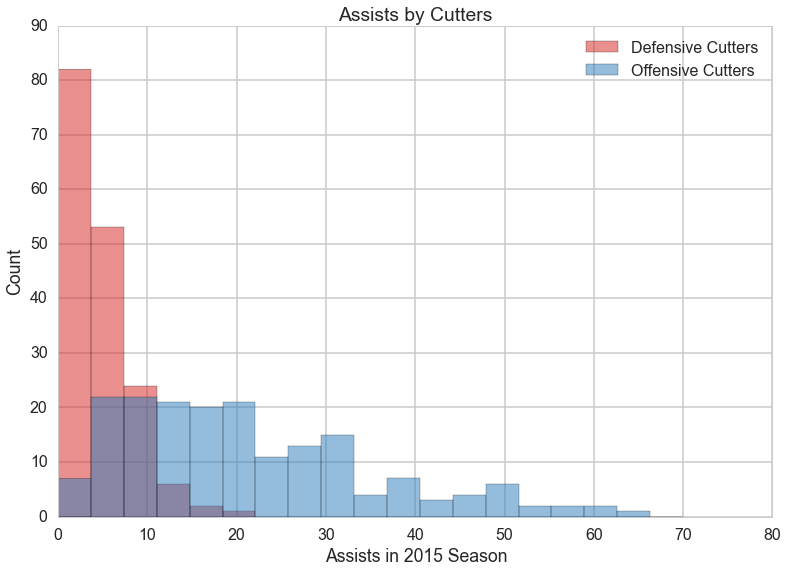

In [169]:
bins = np.linspace(0, 70, 20)

plt.hist(d_cutters["assists"], bins, alpha=.5, 
         color=position_colors["d_cutter"],
         label="Defensive Cutters")
plt.hist(o_cutters["assists"], bins, alpha=.5,
         color=position_colors["o_cutter"],
         label="Offensive Cutters")
plt.title("Assists by Cutters")
plt.ylabel("Count")
plt.xlabel("Assists in 2015 Season")
plt.legend(loc="upper right")

As we can see here, offensive cutters tend to assist much more than dfnsive cutters. Players that can both score and assist are extremely valuable so teams play them on the offensive line.

In [170]:
sc.stats.ttest_ind(o_cutters.assists, d_cutters.assists, equal_var=False)

Ttest_indResult(statistic=14.886003043761511, pvalue=1.0830248451523898e-34)

Performing a t-test here also shows that there is a staitstically significant difference in mean assist between offensive and defensive cutters.

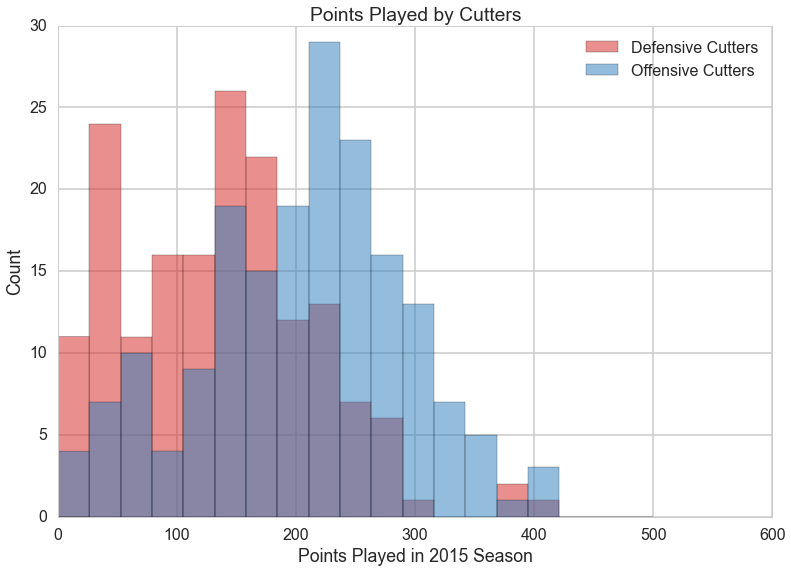

In [143]:
bins = np.linspace(0, 500, 20)

plt.hist(d_cutters["totalpoints"], bins, alpha=.5, 
         color=position_colors["d_cutter"],
         label="Defensive Cutters")
plt.hist(o_cutters["totalpoints"], bins, alpha=.5,
         color=position_colors["o_cutter"],
         label="Offensive Cutters")
plt.title("Points Played by Cutters")
plt.ylabel("Count")
plt.xlabel("Points Played in 2015 Season")
plt.legend(loc="upper right")

We can also see here that offensive cutters played more total points throughout the season than defensive players. This confirms our suspision that offensive cutters tend to be better players - as we know that teams want to play their better players as much as possible. 

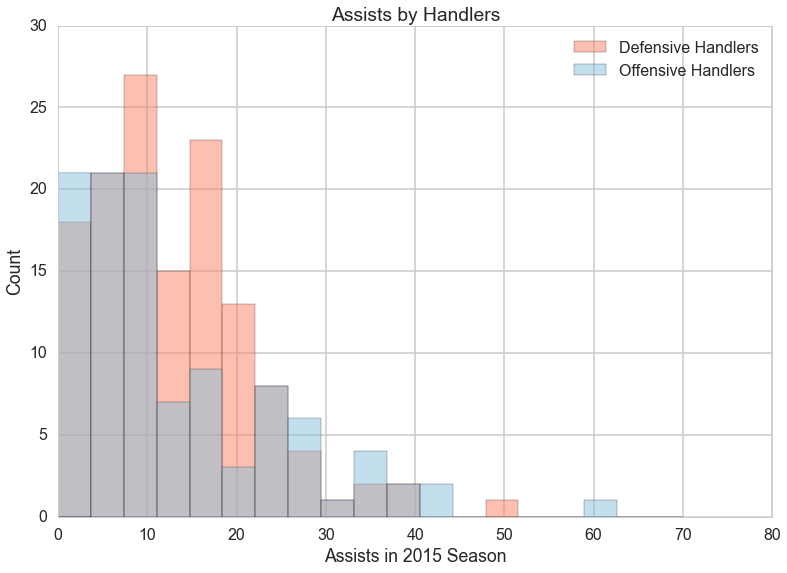

In [140]:
bins = np.linspace(0, 70, 20)

plt.hist(d_handlers["assists"], bins, alpha=.5,
         color=position_colors["d_handler"],
         label="Defensive Handlers")
plt.hist(o_handlers["assists"], bins, alpha=.5,
         color=position_colors["o_handler"],
         label="Offensive Handlers")
plt.title("Assists by Handlers")
plt.ylabel("Count")
plt.xlabel("Assists in 2015 Season")
plt.legend(loc="upper right")

This graph is interesting bcause it appears that offensive and defensive handlers get about the same number of assists. We would normally expect offensive handlers to score more because they get more points on offense, but perhaps they do not score as much because offesive cutters do lots of the assisting on offense.

In [171]:
sc.stats.ttest_ind(o_handlers.assists, d_handlers.assists, equal_var=False)

Ttest_indResult(statistic=0.049549272467241834, pvalue=0.96053432860764976)

This t-test confirms what we see in the histogram above, that the difference in number of assists is about the same for both offensive and defensive handlers.

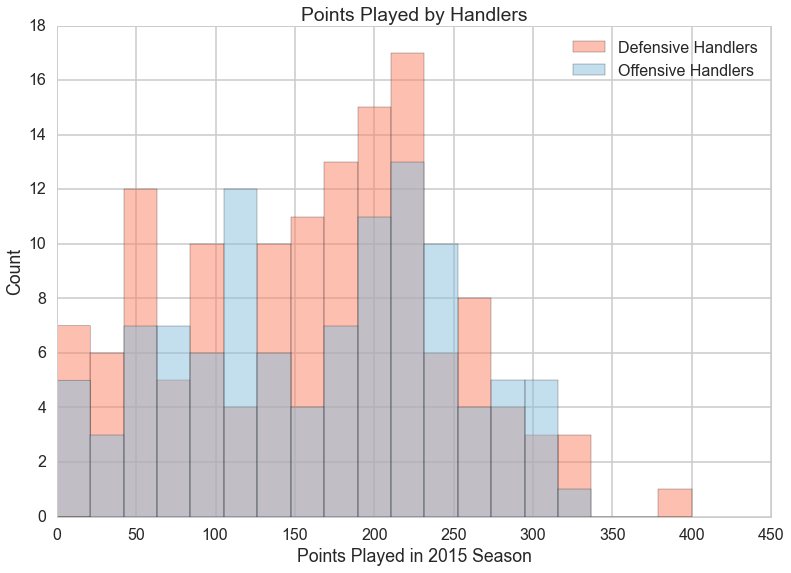

In [174]:
bins = np.linspace(0, 400, 20)

plt.hist(d_handlers["totalpoints"], bins, alpha=.5,
         color=position_colors["d_handler"],
         label="Defensive Handlers")
plt.hist(o_handlers["totalpoints"], bins, alpha=.5,
         color=position_colors["o_handler"],
         label="Offensive Handlers")
plt.title("Points Played by Handlers")
plt.ylabel("Count")
plt.xlabel("Points Played in 2015 Season")
plt.legend(loc="upper right")

Again, we see that the difference between offensive and defensive handlers is really only captured by the proportion of points played on offense. Here we can see that both groups play about the same number of points per game. This is very different from the offensive and defensiv cutters, where offensive cutters seemed to get much more playing time.

In [175]:
sc.stats.ttest_ind(o_handlers.totalpoints, d_handlers.totalpoints, equal_var=False)

Ttest_indResult(statistic=0.28080845722078807, pvalue=0.77911177760485173)

Here we show that the difference in mean number of points played is not statistically significant between these groups.

#### Do handlers get more D's than offensive players?

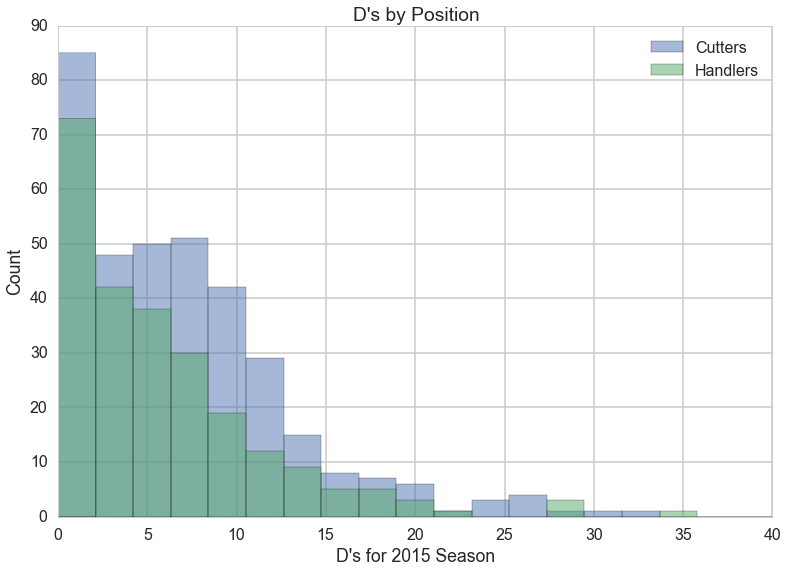

In [178]:
bins = np.linspace(0, 40, 20)


plt.hist(cutters["ds"], bins, alpha=.5,
         label="Cutters")
plt.hist(handlers["ds"], bins, alpha=.5,
         label="Handlers")
plt.title("D's by Position")
plt.ylabel("Count")
plt.xlabel("D's for 2015 Season")
plt.legend(loc="upper right")

These distributions seem to be very similar. While there may be a difference in mean number of D's it looks like neither position is wildly better for getting Ds.

In [179]:
sc.stats.ttest_ind(cutters.ds, handlers.ds, equal_var=False)

Ttest_indResult(statistic=2.1676540984202095, pvalue=0.030629292664566255)

This t-test shows that there is a statistically significant difference in the number of Ds between cutters and handlers. Cutters tend to have slightly more Ds than handlers.

#### Do Handlers or Cutters turn it over more?

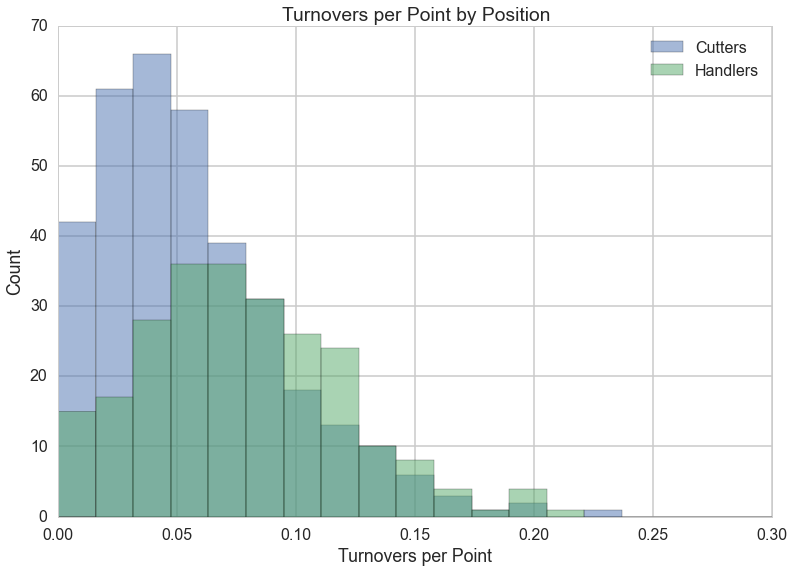

In [186]:
bins = np.linspace(0, .3, 20)

plt.hist(cutters["throwaways"]/cutters["totalpoints"], bins, alpha=.5,
         label="Cutters")
plt.hist(handlers["throwaways"]/handlers["totalpoints"], bins, alpha=.5,
         label="Handlers")
plt.title("Turnovers per Point by Position")
plt.ylabel("Count")
plt.xlabel("Turnovers per Point")
plt.legend(loc="upper right")

From the histograms above it looks as if handlers tend to throw the disc away more than cutters. This is probably because handlers are generally the players that try to make the most difficult throws, turning it over more as a result.

In [187]:
sc.stats.ttest_ind(cutters["throwaways"]/cutters["totalpoints"], handlers.throwaways/handlers.totalpoints, equal_var=False)

Ttest_indResult(statistic=-5.3435876560857052, pvalue=1.3483558710133205e-07)

This t test confirms that there is a statistically dignificant difference between turnovers per point betwee handlers and cutters, where handlers turn the disc over more.

## Conclusion

Our main objective with this analysis was to see if we could identify differences between how certain players played. One of the main differences in playstyle comes from what position a player plays, so we set out to determine which players played which position. Using k-means clustering we were able to differentiate between offensive and defensive cutters and handlers, and also idntified a fifth group of defensive role players.

In looking at these groups, we made some interesting findings. Offensive cutters tended to be the best players: not only did they score the most, but they also were very good at getting assists. Offensive cutters played more points throughout the season than any of the other positions, and for good reason - they were able to score and assist at the highst rates. 

We were also able to destinguish some more nuances in the differences between positions. We observed that cutters tended to have more Ds than handlers did, probably because deeper, longer throws (to cutters) give more time for the defender to earn a D. Another difference we observed was that handlers tend to turn the disc over more than handlers, likely for a similar reason. Cutters are generally not expecte to be as good as throwing, and as result take easier throws. Handlers, on the other hand, take more difficult throws and therefore are more likely to turn the disc over.

